In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [8]:
#chargement du dataset en utilisant la colonne 'Date' comme index
dataset = pd.read_csv("conso.csv", index_col='Date',parse_dates=["Date"])["Totale"]

Date
2020-01-01 00:00:00+00:00    681.28125
2020-01-01 01:00:00+00:00    666.96875
2020-01-01 02:00:00+00:00    733.50000
2020-01-01 03:00:00+00:00    718.34375
2020-01-01 04:00:00+00:00    716.65625
                               ...    
2022-01-22 20:00:00+00:00    262.75000
2022-01-22 21:00:00+00:00    296.75000
2022-01-22 22:00:00+00:00    269.50000
2022-01-22 23:00:00+00:00    254.00000
2022-01-23 00:00:00+00:00    313.25000
Name: Totale, Length: 18073, dtype: float64


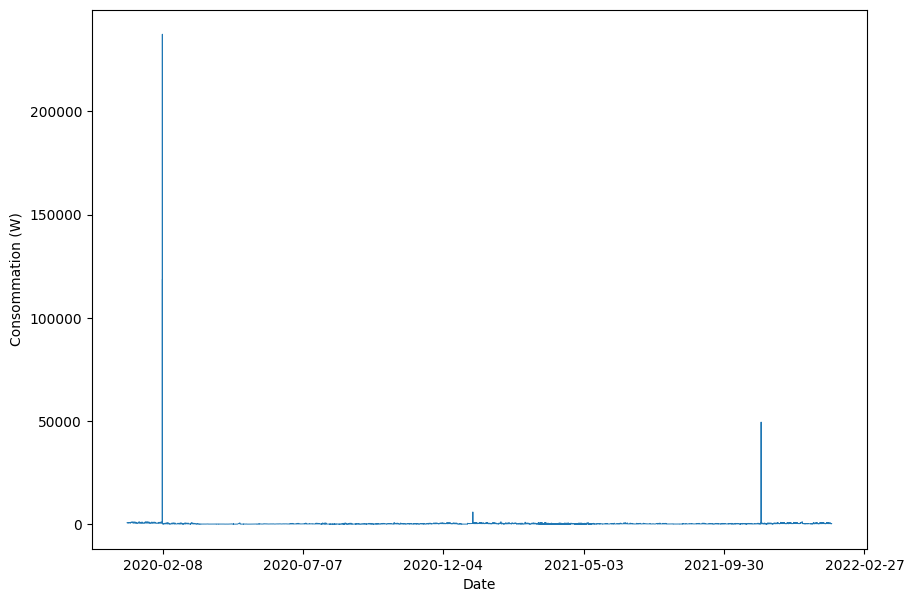

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
axes.plot(dataset, lw=0.7)
axes.set_ylabel('Consommation (W)')
axes.set_xlabel('Date')
axes.xaxis.set_major_locator(MaxNLocator(7))

In [12]:
from scipy import stats

In [13]:
#on vient supprimer les valeurs extrèmes
def outlier(df):

    z_score = stats.zscore(df)
    filtered = (np.abs(z_score) < 2)
    new_df = df[filtered]

    return new_df

Text(0.5, 0, 'Date')

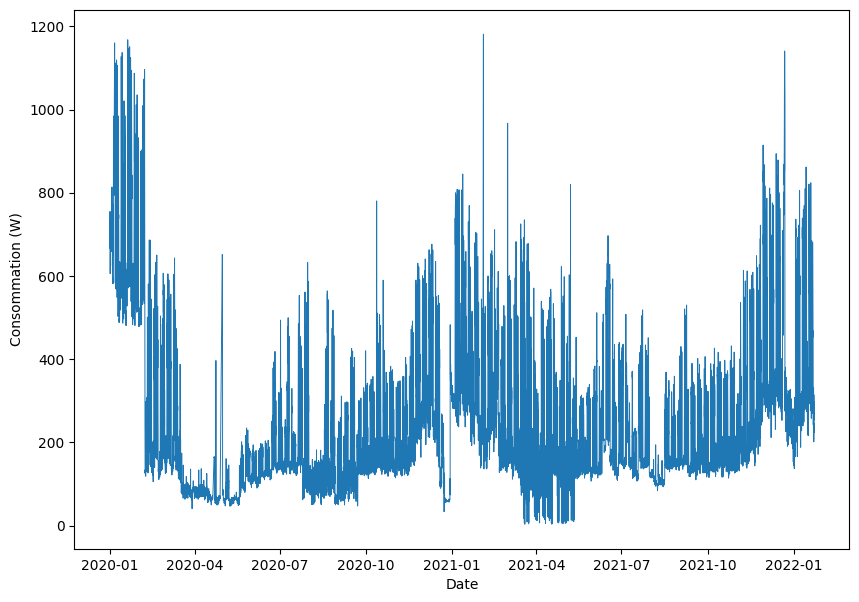

In [14]:
dataset = outlier(dataset)
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
axes.plot(dataset, lw=0.7)
axes.set_ylabel('Consommation (W)')
axes.set_xlabel('Date')

In [15]:
_min = dataset.min()
_max = dataset.max()

In [16]:
def scale(dataset, _min, _max):
    new_dataset = ((dataset - _min) / (_max - _min))
    return new_dataset

def unscale(dataset, _min, _max):
    new_dataset = dataset * (_max - _min) + _min
    return new_dataset

In [17]:
dataset_scaled = scale(dataset, _min, _max)

Text(0.5, 0, 'Date')

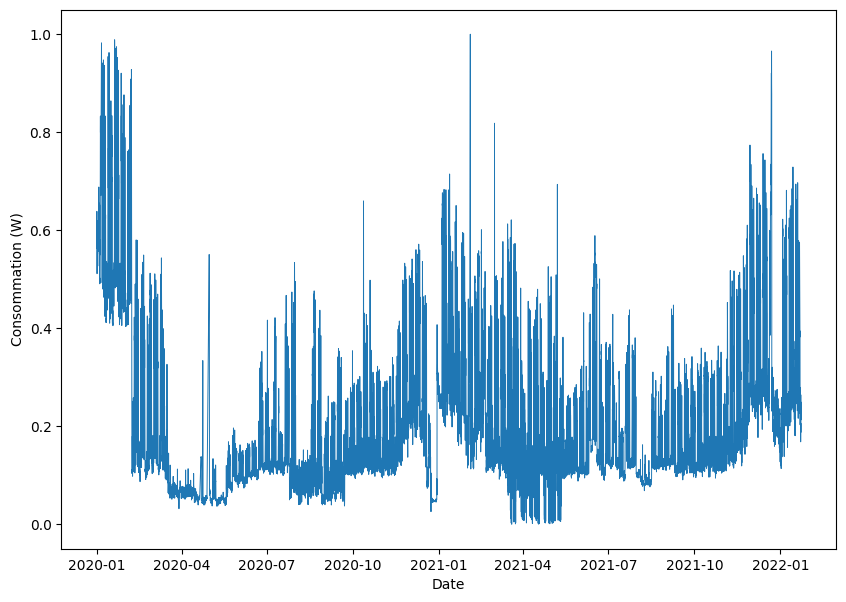

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
axes.plot(dataset_scaled, lw=0.7)
axes.set_ylabel('Consommation (W)')
axes.set_xlabel('Date')

In [19]:
size = int(len(dataset) * 0.95)

In [20]:
seq_len = 11

## Prédiction : LSTM

In [21]:
trainGenerator = TimeseriesGenerator(dataset_scaled[:size].to_numpy(), dataset_scaled[:size].to_numpy(), length=seq_len)
testGenerator = TimeseriesGenerator(dataset_scaled[size:].to_numpy(), dataset_scaled[size:].to_numpy(), length=seq_len)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer

In [23]:
def createSimpleLSTM():
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_len, 1)))
    model.add(LSTM(units=100))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model

In [24]:
model = createSimpleLSTM()
model.fit(trainGenerator, epochs=10, batch_size=128)

Epoch 1/10
134/134 [==============================] - 3s 12ms/step - loss: 0.0075
Epoch 2/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0039
Epoch 3/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0025
Epoch 4/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0023
Epoch 5/10
134/134 [==============================] - 2s 14ms/step - loss: 0.0023
Epoch 6/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0022
Epoch 7/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0022
Epoch 8/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0022
Epoch 9/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0021
Epoch 10/10
134/134 [==============================] - 2s 13ms/step - loss: 0.0021


In [25]:
prediction = model.predict(testGenerator)

7/7 [==============================] - 1s 7ms/step


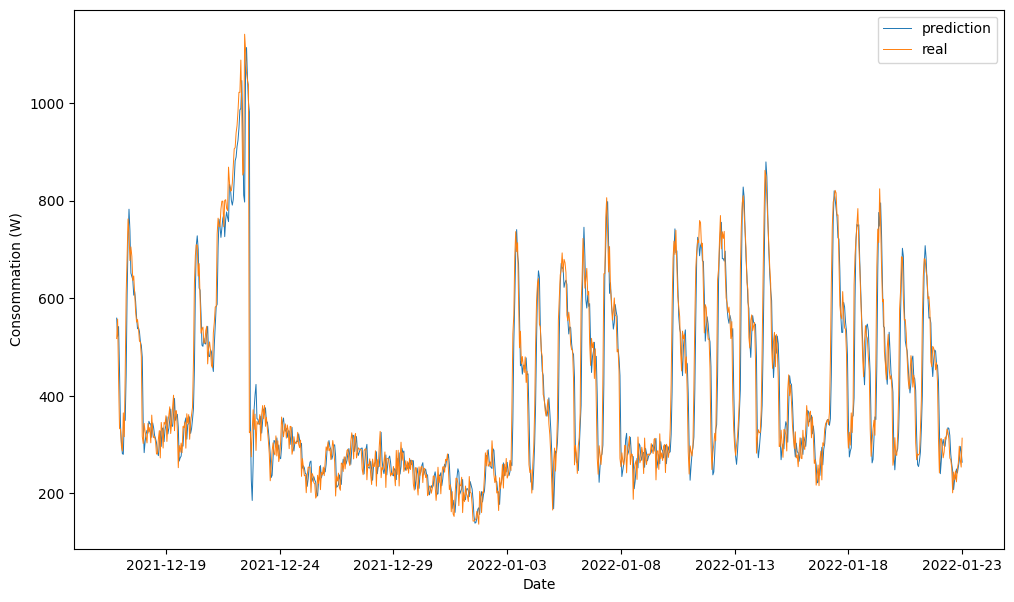

In [31]:
'''
Comme la taille de la séquence est 11, la première valeur prédite par le modèle est la 12-ième, il faut donc enlever les 11 premières valeurs du jeu de test.
Ce phénomène est propre à l'entrainement des modèles de Keras avec un TimeseriesGenerator
'''
DateDataset=dataset_scaled[size+11:].reset_index()["Date"]


fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(DateDataset, unscale(prediction,_min,_max), lw=0.7, label='prediction')
axes.plot(DateDataset, unscale(dataset_scaled[size+11:].to_numpy(),_min,_max), lw=0.7, label='real')
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("Date")
axes.xaxis.set_major_locator(MaxNLocator(9))
axes.legend()

In [32]:
np.sqrt(mean_squared_error(prediction, dataset_scaled[size:].to_numpy()[11:]))

0.049225757286568285

## Prédiction : RandomForestRegressor

In [35]:
def create_dataset(dataset, seq_len):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_len-1):
        a = dataset[i:(i + seq_len)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len])
    return np.array(dataX), np.array(dataY)

In [36]:
dataX, dataY = create_dataset(dataset_scaled[:size].to_numpy(), seq_len)
testX, testY = create_dataset(dataset_scaled[size:].to_numpy(), seq_len)

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
model = RandomForestRegressor(n_estimators=5, max_depth=4)

In [39]:
model.fit(dataX, dataY)

RandomForestRegressor(max_depth=4, n_estimators=5)

In [50]:
prediction = model.predict(testX)

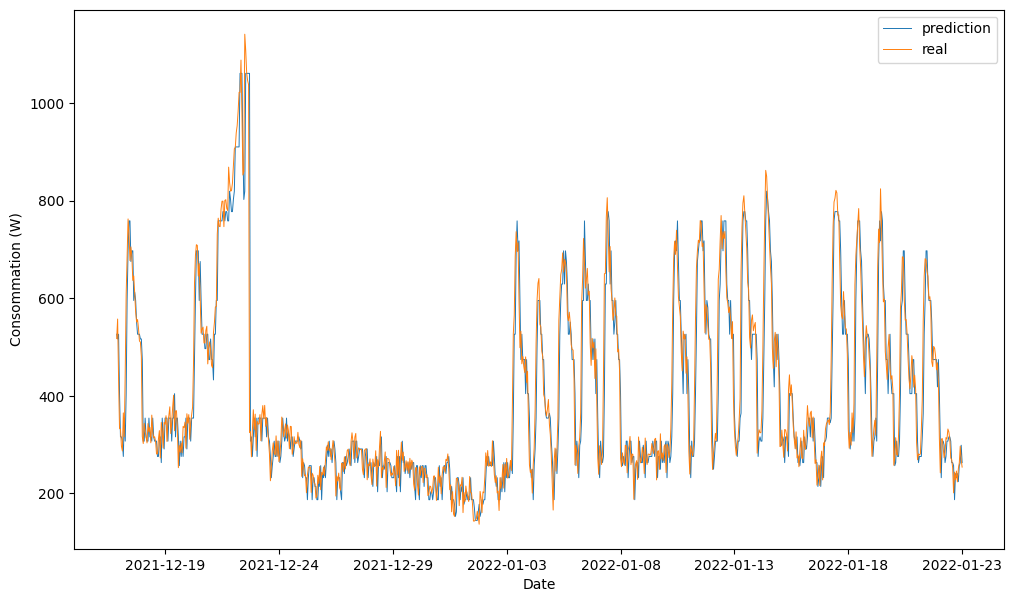

In [54]:
DateDataset=dataset_scaled[size+12:].reset_index()["Date"]

fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(DateDataset, unscale(prediction,_min,_max), lw=0.7, label='prediction')
axes.plot(DateDataset, unscale(testY,_min,_max), lw=0.7, label='real')
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("Date")
axes.xaxis.set_major_locator(MaxNLocator(9))
axes.legend()

In [55]:
np.sqrt(mean_squared_error(prediction, testY))

0.05226948098880951